# Analysis of scraped Immoweb data - The Chainsmokers

## Imports

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
immo = pd.read_csv('../data/clean/details_clean.csv')

pd.set_option('display.max_columns', None) # Displays all the columns

C:\Users\Jean\AppData\Local\Temp\ipykernel_6776\677958950.py:1: DtypeWarning: Columns (88,105,106,118) have mixed types. Specify dtype option on import or set low_memory=False.
  immo = pd.read_csv('../data/clean/details_clean.csv')


## Cleaning

Here we are:
* changing *numpy not a number* type to *None* type
* removing some rows which either shouldn't be here (annuity properties) or need further implementation in the scraper (group developments)
* removing substrings to clean up columns for type casting
* displaying the first 5 columns of the dataframe

In [3]:
immo = immo.replace(np.nan, None)


# Replace 'Not specified' with None as in this case it serves no purpose. If a consumption is not provided it might as well be absent
immo['Primary energy consumption'] = immo['Primary energy consumption'].replace('Not specified', None)
immo['CO₂ emission'] = immo['CO₂ emission'].replace('Not specified', None)
immo['Yearly theoretical total energy consumption'] = immo['Yearly theoretical total energy consumption'].replace('Not specified', None)


# Remove annuity properties
substring = '€'
filter = immo['Price'].str.contains(substring)
immo = immo[~filter]


# Remove group developments for dataset
immo = immo[
    (immo["Subtype_of_property"] != "New-real-estate-project-houses")
    & (immo["Subtype_of_property"] != "New-real-estate-project-apartments")
]


# Remove substrings from strings
immo['Price'] = immo['Price'].str.replace(r'Starting price : ','')
immo['CO₂ emission'] = immo['CO₂ emission'].str.replace(r' kg CO₂/m²','')
immo['Yearly theoretical total energy consumption'] = immo['Yearly theoretical total energy consumption'].str.replace(r' kWh/year','')
immo['Building price excluding VAT'] = immo['Building price excluding VAT'].str.replace(r'€','')
immo['Building price excluding VAT'] = immo['Building price excluding VAT'].str.replace(r',','')
immo['Total price including taxes*'] = immo['Total price including taxes*'].str.replace(r'€','')
immo['Total price including taxes*'] = immo['Total price including taxes*'].str.replace(r',','')
immo['Street frontage width'] = immo['Street frontage width'].str.replace(r' m','')

# Remove 'Unnamed: 0' column as that seems to just be a key column generated from 'raw' data
immo.drop(columns='Unnamed: 0', inplace=True)

immo.head()

,Property_ID,Locality,Price,Subtype_of_property,Type_of_property,Available as of,Neighbourhood or locality,Outdoor parking spaces,Primary energy consumption,Energy class,Reference number of the EPC report,CO₂ emission,Yearly theoretical total energy consumption,Planning permission obtained,Subdivision permit,Possible priority purchase right,Proceedings for breach of planning regulations,Flood zone type,Tenement building,Address,Website,External reference,Postcode,Url,Available date,Construction year,Number of floors,Building condition,Street frontage width,Number of frontages,Covered parking spaces,Surroundings type,Living area,Kitchen type,Bedrooms,Bedroom 1 surface,Bedroom 2 surface,Bedroom 3 surface,Bathrooms,Toilets,Basement,Attic,Furnished,Surface of the plot,Width of the lot on the street,Garden surface,Terrace surface,As built plan,Heating type,Double glazing,Total ground floor buildable,Latest land use designation,Cadastral income,Living room surface,Kitchen surface,Bedroom 4 surface,Office surface,Office,Connection to sewer network,Dining room,Bedroom 5 surface,Shower rooms,Armored door,"Gas, water & electricity",Virtual visit,Basement surface,Dressing room,Professional space,Attic surface,Land is facing street,Wooded land,Plot at rear,Flat land,Garden orientation,Terrace orientation,Conformity certification for fuel tanks,Heat pump,Photovoltaic solar panels,Thermic solar panels,Common water heater,Type of building,Terrace,Laundry room,Isolated,Obligation to build,Unnamed: 86,Agent's name,E-mail,Phone number,Floor,Garden,E-level (overall energy performance),Living room,Property name,Sea view,Building price excluding VAT,Land price excluding taxes,Building VAT,Taxes related to land,Total price including taxes*,How many fireplaces?,Professional space surface,Monthly charges,Number of annexes,EPC description,Extra information,Percentage rented,Current monthly revenue,Value of the property,Lump sum,Monthly annuity,Indexed annuity,Reversionary annuity,Bare ownership sale,Number of annuitants,Age of annuitant,Maximum duration of annuity,Age of annuitants,Venue of the sale,Single session,Terms of visit
1,11135548,Ronse,259000,Villa,House,After signing the deed,Vlaamse Ardennen,5.0,471,E,3033404,8899,None,0,0,0,No,Non flood zone,0,Stationstraat 30,None,5847455,9600.0,https://www.immoweb.be/en/classified/villa/for...,May 20 2024 - 12:00 AM,1959.0,2.0,To renovate,10,3.0,1.0,Isolated,165.0,Semi equipped,3.0,14.0,12.0,8.0,1.0,1.0,1,1,0,674.0,None,351.0,30.0,No,Gas,1,95.0,Area of landscape interest,None,None,None,None,None,0,None,0,None,None,None,0,None,None,None,None,None,None,None,None,0,None,None,None,None,None,0,None,None,0,0,None,None,None,None,None,None,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
6,11135545,Zottegem,645000,Villa,House,After signing the deed,Oost-Vlaanderen,4.0,462,E,20230818-0002967446-RES-1,None,None,0,0,0,None,Non flood zone,0,Sint-Denijslaan 1,None,5863623,9620.0,https://www.immoweb.be/en/classified/villa/for...,None,1976.0,1.0,Good,18,4.0,2.0,Urban,272.0,Installed,4.0,17.0,17.0,15.0,1.0,2.0,0,0,0,2627.0,None,2327.0,26.0,None,Fuel oil,1,None,"Living area (residential, urban or rural)",None,53.0,28.0,14.0,12.0,1,Connected,0,None,None,None,0,None,None,None,None,None,None,None,None,0,None,None,None,None,None,0,None,None,0,0,None,None,None,None,None,None,None,0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
7,11135101,Seraing,329000,Mixed-use-building,House,After signing the deed,None,6.0,418,E,20240112001720,None,72247,0,0,0,No,Non flood zone,1,Rue J. Wettinck 49,None,5863385,4100.0,https://www.immoweb.be/en/classified/mixed-use...,None,1900.0,2.0,To renovate,12,2.0,1.0,Isolated,110.0,Not installed,5.0,12.0,18.0,15.0,4.0,4.0,0,0,0,1640.0,None,465.0,45.0,No,Gas,1,1170.0,"Living area (residential, 

In [4]:
immo['Yearly theoretical total energy consumption']

1         None
6         None
7        72247
8         None
9         None
         ...  
18208     None
18209     None
18210     None
18211     None
18212     None
Name: Yearly theoretical total energy consumption, Length: 17585, dtype: object

Here we define some lists with the various column names which we will be type casting. This is because some of our numerical values are strings, so we just want to be sure that they are numerical

In [5]:
map_to_float = [
    "Price",
    "Number of floors",
    "Number of frontages",
    "Covered parking spaces",
    "Outdoor parking spaces",
    "Living area",
    "Bedrooms",
    "Bedroom 1 surface",
    "Bedroom 2 surface",
    "Bedroom 3 surface",
    "Bedroom 4 surface",
    "Bedroom 5 surface",
    "Bathrooms",
    "Toilets",
    "Surface of the plot",
    "Width of the lot on the street",
    "Garden surface",
    "Terrace surface",
    "CO₂ emission",
    "Yearly theoretical total energy consumption",
    "Total ground floor buildable",
    "Cadastral income",
    "Shower rooms",
    "Living room surface",
    "Kitchen surface",
    "Office surface",
    "Basement surface",
    "Attic surface",
    "E-level (overall energy performance)",
    "How many fireplaces?",
    "Floor",
    "Professional space surface",
    "Number of annexes",
    "Building price excluding VAT",
    "Number of annuitants",
    "Age of annuitant",
    "Maximum duration of annuity",
    "Percentage rented",
    "Current monthly revenue",
    "Construction year",
    "Postcode",
    "Street frontage width",
    "Monthly charges",
    "Primary energy consumption"
]

map_to_binary = [
    "As built plan",
    "Connection to sewer network",
    "Armored door",
    "Dressing room",
    "Virtual visit",
    "Professional space",
    "Proceedings for breach of planning regulations",
    "Land is facing street",
    "Wooded land",
    "Plot at rear",
    "Heat pump",
    "Photovoltaic solar panels",
    "Common water heater",
    "Living room",
    "Garden",
    "Isolated",
    "Obligation to build",
    "Indexed annuity",
    "Reversionary annuity",
    "Bare ownership sale",
    "Sea view",
    "Single session"
]

immo[map_to_float] = immo[map_to_float].astype(float).round(2)



We create a new column called 'Municipality', which is based on the postcode

In [6]:
#Brussels: numbers from 1000 to 1100
#Flanders: numbers from 1500 to 4000 and 8000 to 10000
#Wallonia: numbers from 1100 to 1500 and from 4000 to 8000


brussels_range = range(1000,1100)
flanders_range = list(range(1500,4000)) + list(range(8000,10000))
wallonia_range = list(range(1100,1500)) + list(range(4000,8000))

def municipality_from_pc(postcode):
    if postcode in brussels_range:
        return "Brussels"
    elif postcode in flanders_range:
        return "Flanders"
    elif postcode in wallonia_range:
        return "Wallonia"
    
immo["Municipality"] = immo["Postcode"].apply(municipality_from_pc)

Here we will remove empty columns

In [7]:
print(immo.columns)

immo.dropna(how='all', axis=1, inplace=True)

print(immo.columns)

Index(['Property_ID', 'Locality', 'Price', 'Subtype_of_property',
       'Type_of_property', 'Available as of', 'Neighbourhood or locality',
       'Outdoor parking spaces', 'Primary energy consumption', 'Energy class',
       ...
       'Reversionary annuity', 'Bare ownership sale', 'Number of annuitants',
       'Age of annuitant', 'Maximum duration of annuity', 'Age of annuitants',
       'Venue of the sale', 'Single session', 'Terms of visit',
       'Municipality'],
      dtype='object', length=122)
Index(['Property_ID', 'Locality', 'Price', 'Subtype_of_property',
       'Type_of_property', 'Available as of', 'Neighbourhood or locality',
       'Outdoor parking spaces', 'Primary energy consumption', 'Energy class',
       ...
       'Total price including taxes*', 'How many fireplaces?',
       'Professional space surface', 'Number of annexes', 'EPC description',
       'Extra information', 'Percentage rented', 'Current monthly revenue',
       'Single session', 'Municipality'],
 

## Testing cells below

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
pd.set_option("display.max_rows", None)

# Answering the questions

<div class="alert alert-block alert-info">
<b>How many observations and features do you have?</b>
</div>

In [16]:
print(f'Number of properties: {immo.shape[0]}')
print(f'Number of initial features: {immo.shape[1]}')


Number of properties: 17585
Number of initial features: 105


<div class="alert alert-block alert-info">
<b>What is the proportion of missing values per column?</b>
</div>

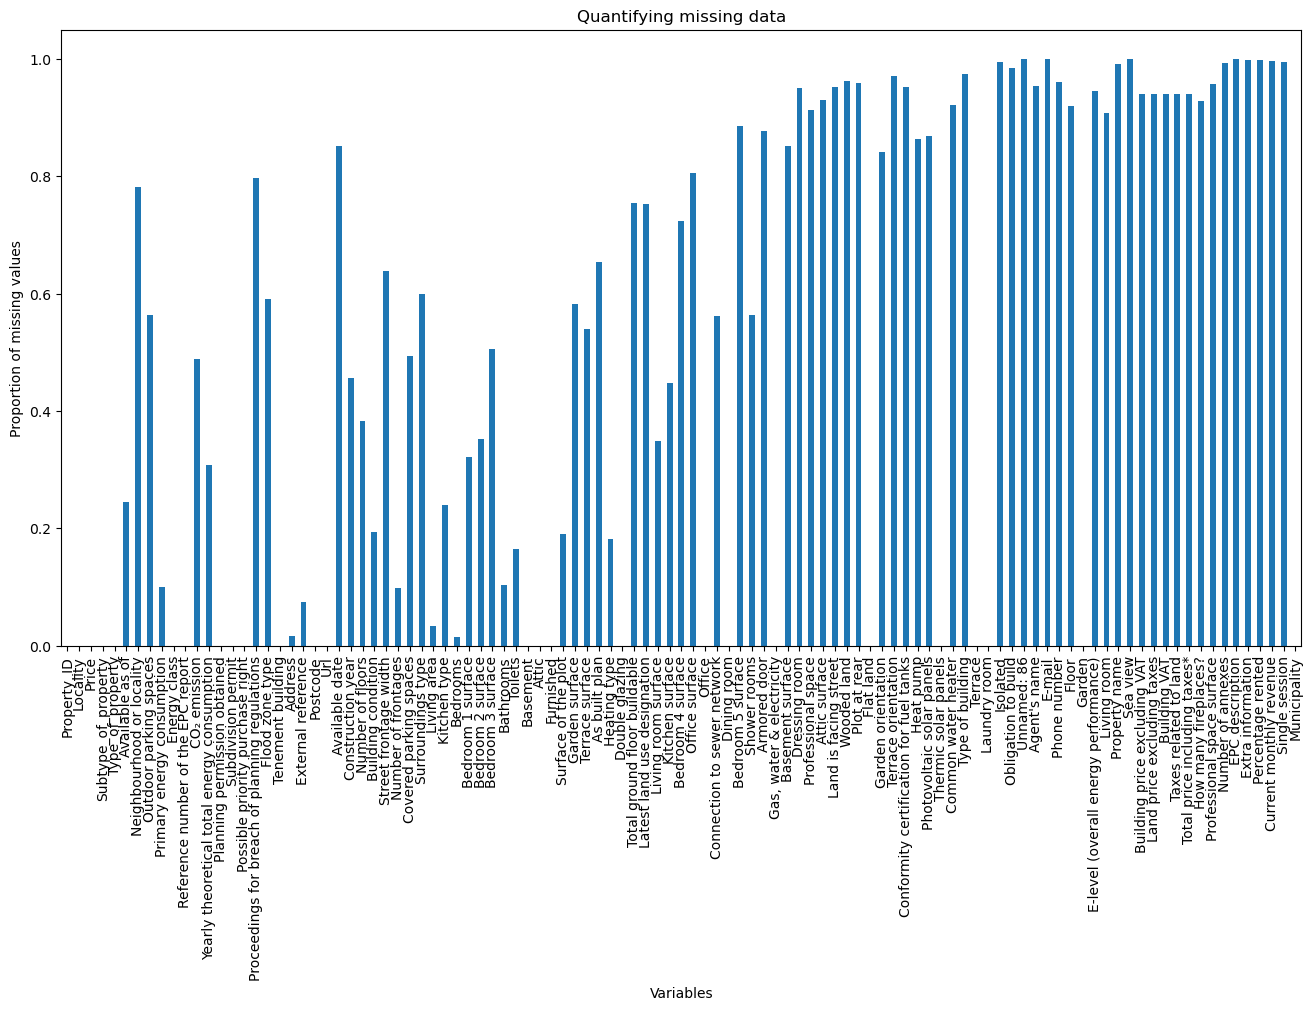

In [17]:
missing_proportion = immo[immo['Municipality'] == 'Wallonia'].isnull().mean()

# Condition
#missing_proportion = missing_proportion[missing_proportion > 0.9] # Only plot features with more than 90% values missing

missing_proportion.plot.bar(figsize=(16,8))

plt.ylabel('Proportion of missing values')
plt.xlabel('Variables')
plt.title('Quantifying missing data')

plt.show()

# Print series

#print(immo.isnull().mean())

<div class="alert alert-block alert-info">
<b>Which variables would you delete and why?</b>

1. All the empty columns (which has already been done)
2. The values below because they make up 5% or less of the data and so are not very useful during the overall analysis
</div>

In [18]:
missing_proportion = missing_proportion[missing_proportion > 0.95]
print(missing_proportion)

Land is facing street                      0.952357
Wooded land                                0.961985
Plot at rear                               0.958167
Terrace orientation                        0.970784
Conformity certification for fuel tanks    0.952191
Type of building                           0.973938
Isolated                                   0.994522
Obligation to build                        0.984728
Unnamed: 86                                1.000000
Agent's name                               0.953519
E-mail                                     1.000000
Phone number                               0.961321
Property name                              0.991368
Sea view                                   1.000000
Professional space surface                 0.956839
Number of annexes                          0.993194
EPC description                            0.999834
Extra information                          0.997344
Percentage rented                          0.998340
Current mont

In [19]:
# Dropping the above mentioned columns

names = missing_proportion[missing_proportion > 0.95].index

immo.drop(columns=names, inplace=True)

print(immo.columns, len(immo.columns))

immo.drop(columns='Building price excluding VAT', inplace=True) # Has the same values as Price, but more missing values

Index(['Property_ID', 'Locality', 'Price', 'Subtype_of_property',
       'Type_of_property', 'Available as of', 'Neighbourhood or locality',
       'Outdoor parking spaces', 'Primary energy consumption', 'Energy class',
       'Reference number of the EPC report', 'CO₂ emission',
       'Yearly theoretical total energy consumption',
       'Planning permission obtained', 'Subdivision permit',
       'Possible priority purchase right',
       'Proceedings for breach of planning regulations', 'Flood zone type',
       'Tenement building', 'Address', 'External reference', 'Postcode', 'Url',
       'Available date', 'Construction year', 'Number of floors',
       'Building condition', 'Street frontage width', 'Number of frontages',
       'Covered parking spaces', 'Surroundings type', 'Living area',
       'Kitchen type', 'Bedrooms', 'Bedroom 1 surface', 'Bedroom 2 surface',
       'Bedroom 3 surface', 'Bathrooms', 'Toilets', 'Basement', 'Attic',
       'Furnished', 'Surface of the plot', 

<div class="alert alert-block alert-info">
<b>What variables are most subject to outliers?</b>
</div>

<Axes: xlabel='Price', ylabel='Subtype_of_property'>

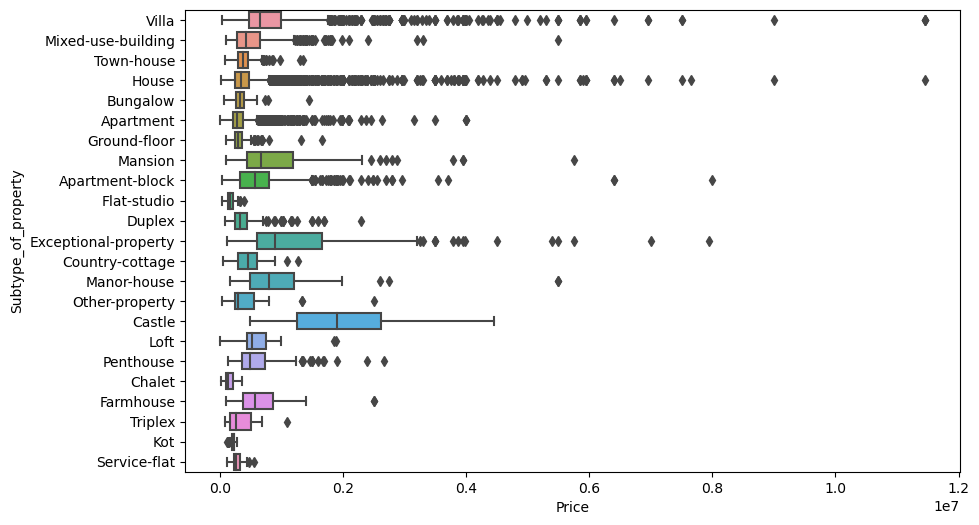

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=immo['Price'], y=immo['Subtype_of_property'])

In [21]:
#immo.plot(kind='box')

C:\Users\Jean\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Mean: 488172 - Median: 350000 - Mode: 299000


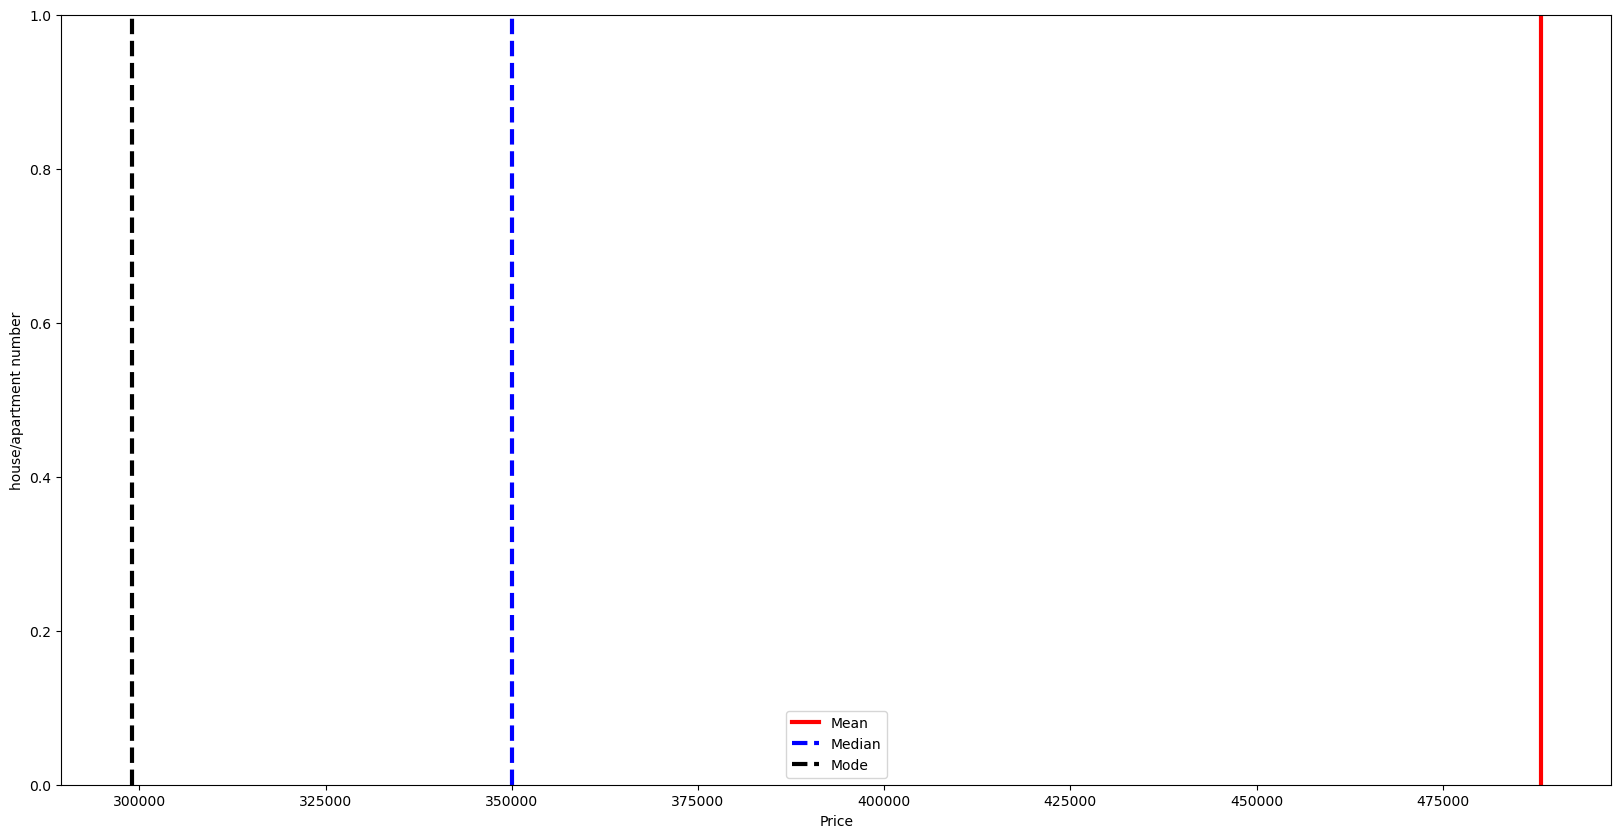

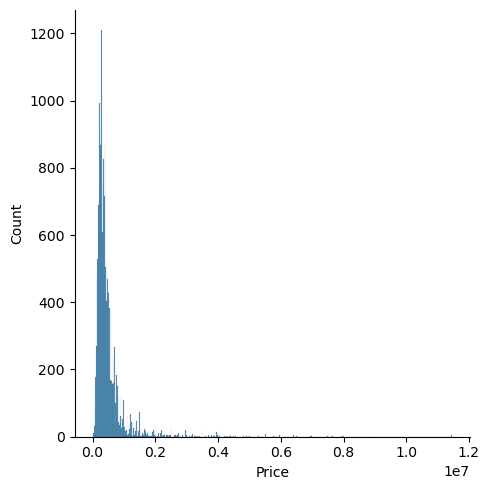

In [22]:
# Resize the graph size
plt.figure(figsize=(20,10))
plt.ticklabel_format(style='plain', axis='x')

# Math and display the Mode, Median and Mean
mean = immo['Price'].mean()
median = immo['Price'].median()
mode = immo['Price'].mode()[0]

plt.axvline(mean, color='r', linewidth=3,label='Mean')
plt.axvline(median, color='b', linestyle='dashed', linewidth=3,label='Median')
plt.axvline(mode, color='k', linestyle='dashed', linewidth=3,label='Mode')

# Label the axis
plt.xlabel('Price')
plt.ylabel('house/apartment number')
plt.legend()

# Show the graph
ax = sns.displot(immo['Price'])

mean=round(mean)
median=round(median)
mode=round(mode)

print(f"Mean: {round(mean)} - Median: {round(median)} - Mode: {round(mode)}")

In [23]:
skew = immo['Price'].skew()
kurtosis = immo['Price'].kurt()

print(f"Skew: {skew} - Kurtosis: {kurtosis}")

Skew: 6.759886878846267 - Kurtosis: 74.0955291864722


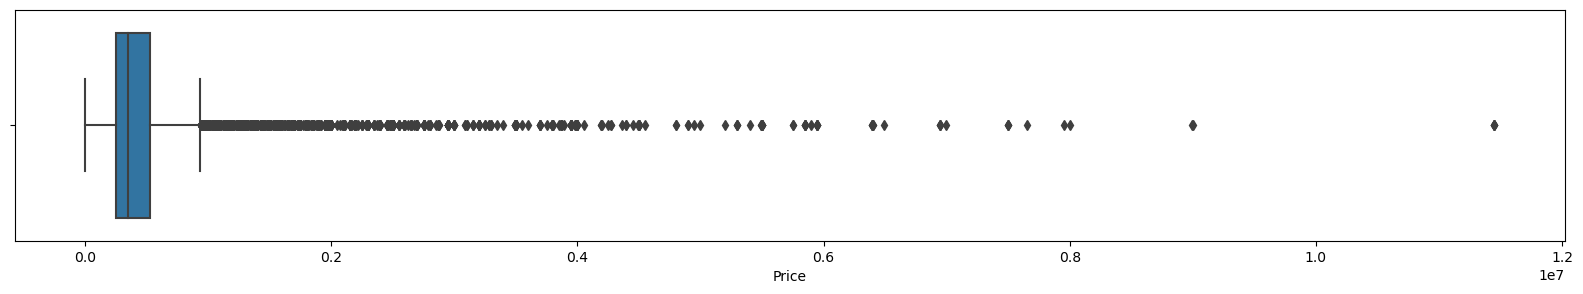

In [24]:
# Print the outliers horizontally
plt.figure(figsize=(20,3))
sns.boxplot(x=immo["Price"]);

<div class="alert alert-block alert-info">
<b>How many qualitative and quantitative variables are there? How would you transform the qualitative values into numerical values?</b>
    
1. Some qualitative values are easier to transform in quantitative ones, for example anything which has a binary output "Yes/No", "True/False", "Exists/Does not exist" can become 1/0
2. Some qualitative (categorical) values like 'Energy Class' have a few ways they could be transformed. The letter classifications A, B, C could turn into numbers -> 1, 2, 3 which would retains it's categorical nature, but maybe one would instead prefer to map A, B, C -> 3, 2, 1 for example to show that A is 'better' than B or C (but I think this is for ML). Another way to deal with it, since it is a rating representing a range of values when it comes to energy, would be to convert it to the average Energy Index for that class.
    
    For example:
    C = a range of 114 - 132 -> 123
    
</div>

In [25]:
print(f'Quantitative values: {len(map_to_float)}')
print(f'Qualitative values: {immo.shape[1] - len(map_to_float)}')
print(immo.shape)

Quantitative values: 44
Qualitative values: 39
(17585, 83)


#### Wanted to create a new column converting the Energy levels to Energy Index, so that we can treat them numerically, but have not managed to yet

<BarContainer object of 15117 artists>

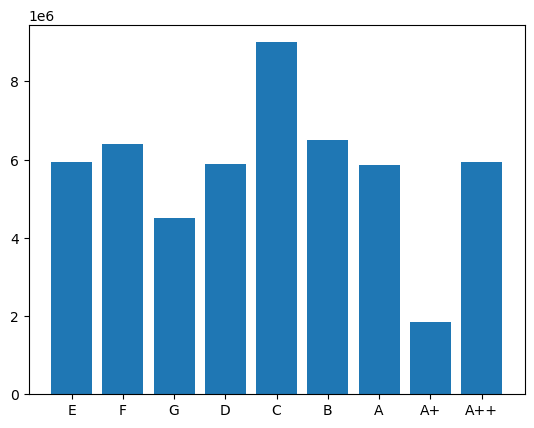

In [26]:
filtered_energy = immo[~immo['Energy class'].isin(['Not specified', 'F_C', 'A+_A++'])]

fig, ax = plt.subplots()

ax.bar(filtered_energy['Energy class'], filtered_energy['Price'])

<div class="alert alert-block alert-info">
<b>What is the correlation between the variables and the price? Why do you think some variables are more correlated than others?</b>
</div>

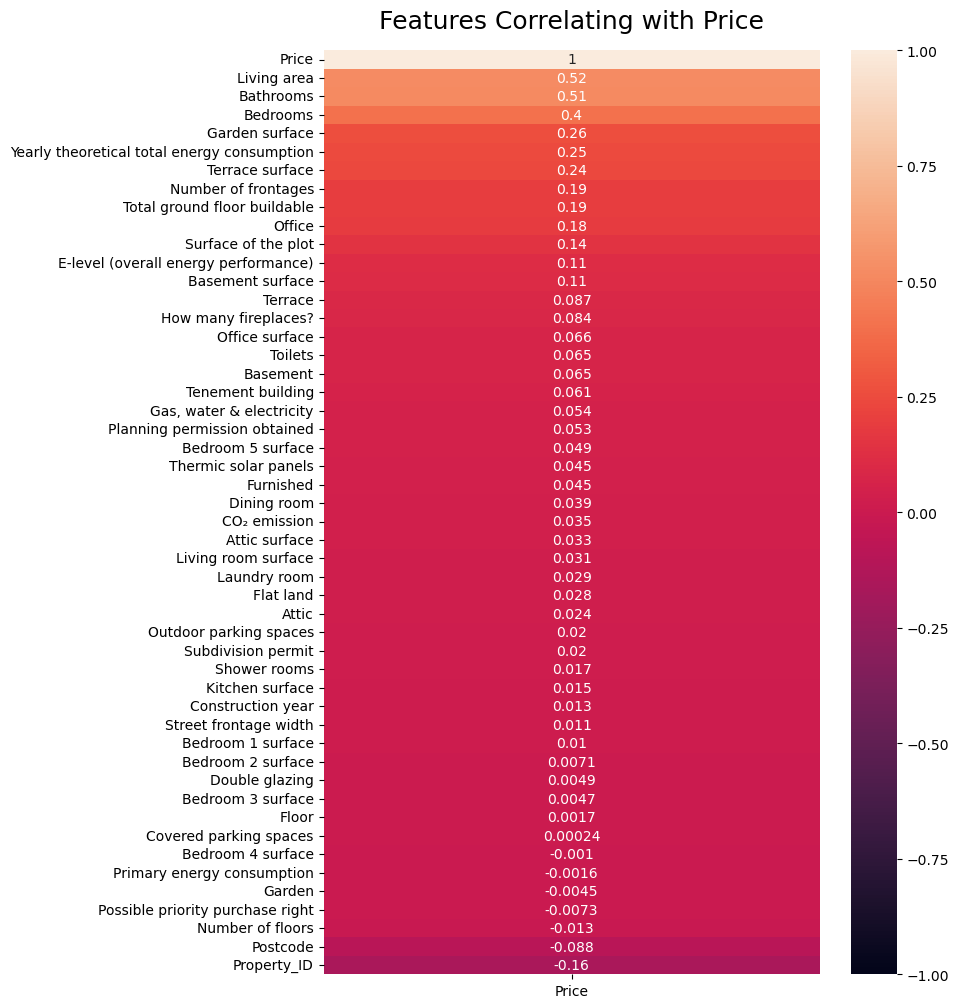

In [27]:
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(immo.corr(numeric_only=True)[['Price']].sort_values(by='Price', ascending=False), vmin=-1, vmax=1, annot=True)

heatmap.set_title('Features Correlating with Price', fontdict={'fontsize':18}, pad=16);

['Flanders', 'Wallonia', 'Brussels']


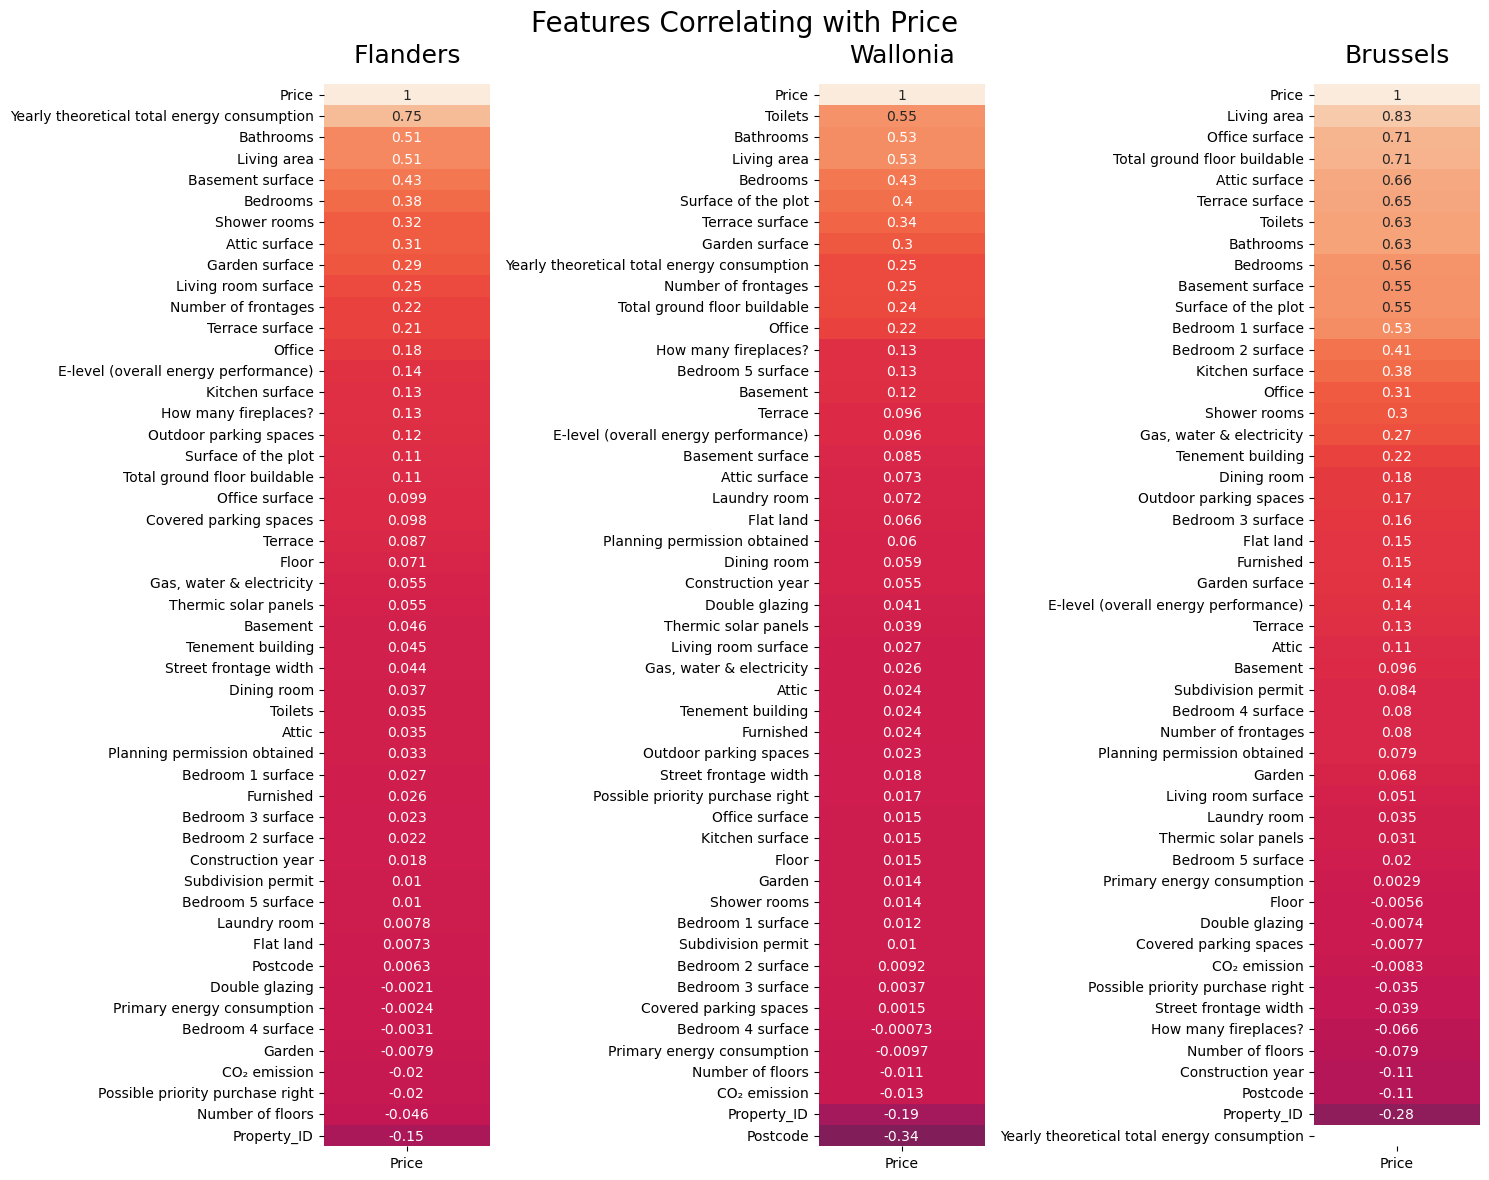

In [28]:
#plt.figure(figsize=(8, 12))

fig, axes = plt.subplots(1, 3, figsize=(15, 12))

fig.suptitle('Features Correlating with Price', fontsize=20)


#sns.boxplot(ax=axes[0, 0], data=pokemon, x='Generation', y='Attack')

municipality = immo.Municipality.unique().tolist()
municipality = [i for i in municipality if i is not None]
print(municipality)



for i in range(len(municipality)):
    immo_region = immo[immo['Municipality'] == municipality[i]]
    heatmap = sns.heatmap(immo_region.corr(numeric_only=True)[['Price']].sort_values(by='Price', ascending=False), ax=axes[i], vmin=-1, vmax=1, annot=True, cbar=False)
    heatmap.set_title(f'{municipality[i]}', fontdict={'fontsize':18}, pad=16);
    
fig.tight_layout()
#immo_brussels = immo[immo['Municipality'] == 'Flanders']

#heatmap = sns.heatmap(immo_brussels.corr(numeric_only=True)[['Price']].sort_values(by='Price', ascending=False), vmin=-1, vmax=1, annot=True)

#heatmap.set_title('Features Correlating with Price (Brussels)', fontdict={'fontsize':18}, pad=16);

In [29]:
#print(immo[['Price', 'Building price excluding VAT']])

In [30]:
immo['Municipality'].value_counts()

Municipality
Flanders    10486
Wallonia     6024
Brussels     1006
Name: count, dtype: int64

<div class="alert alert-block alert-info">
<b>How are the variables themselves correlated to each other? Can you find groups of variables that are correlated together?</b>
</div>

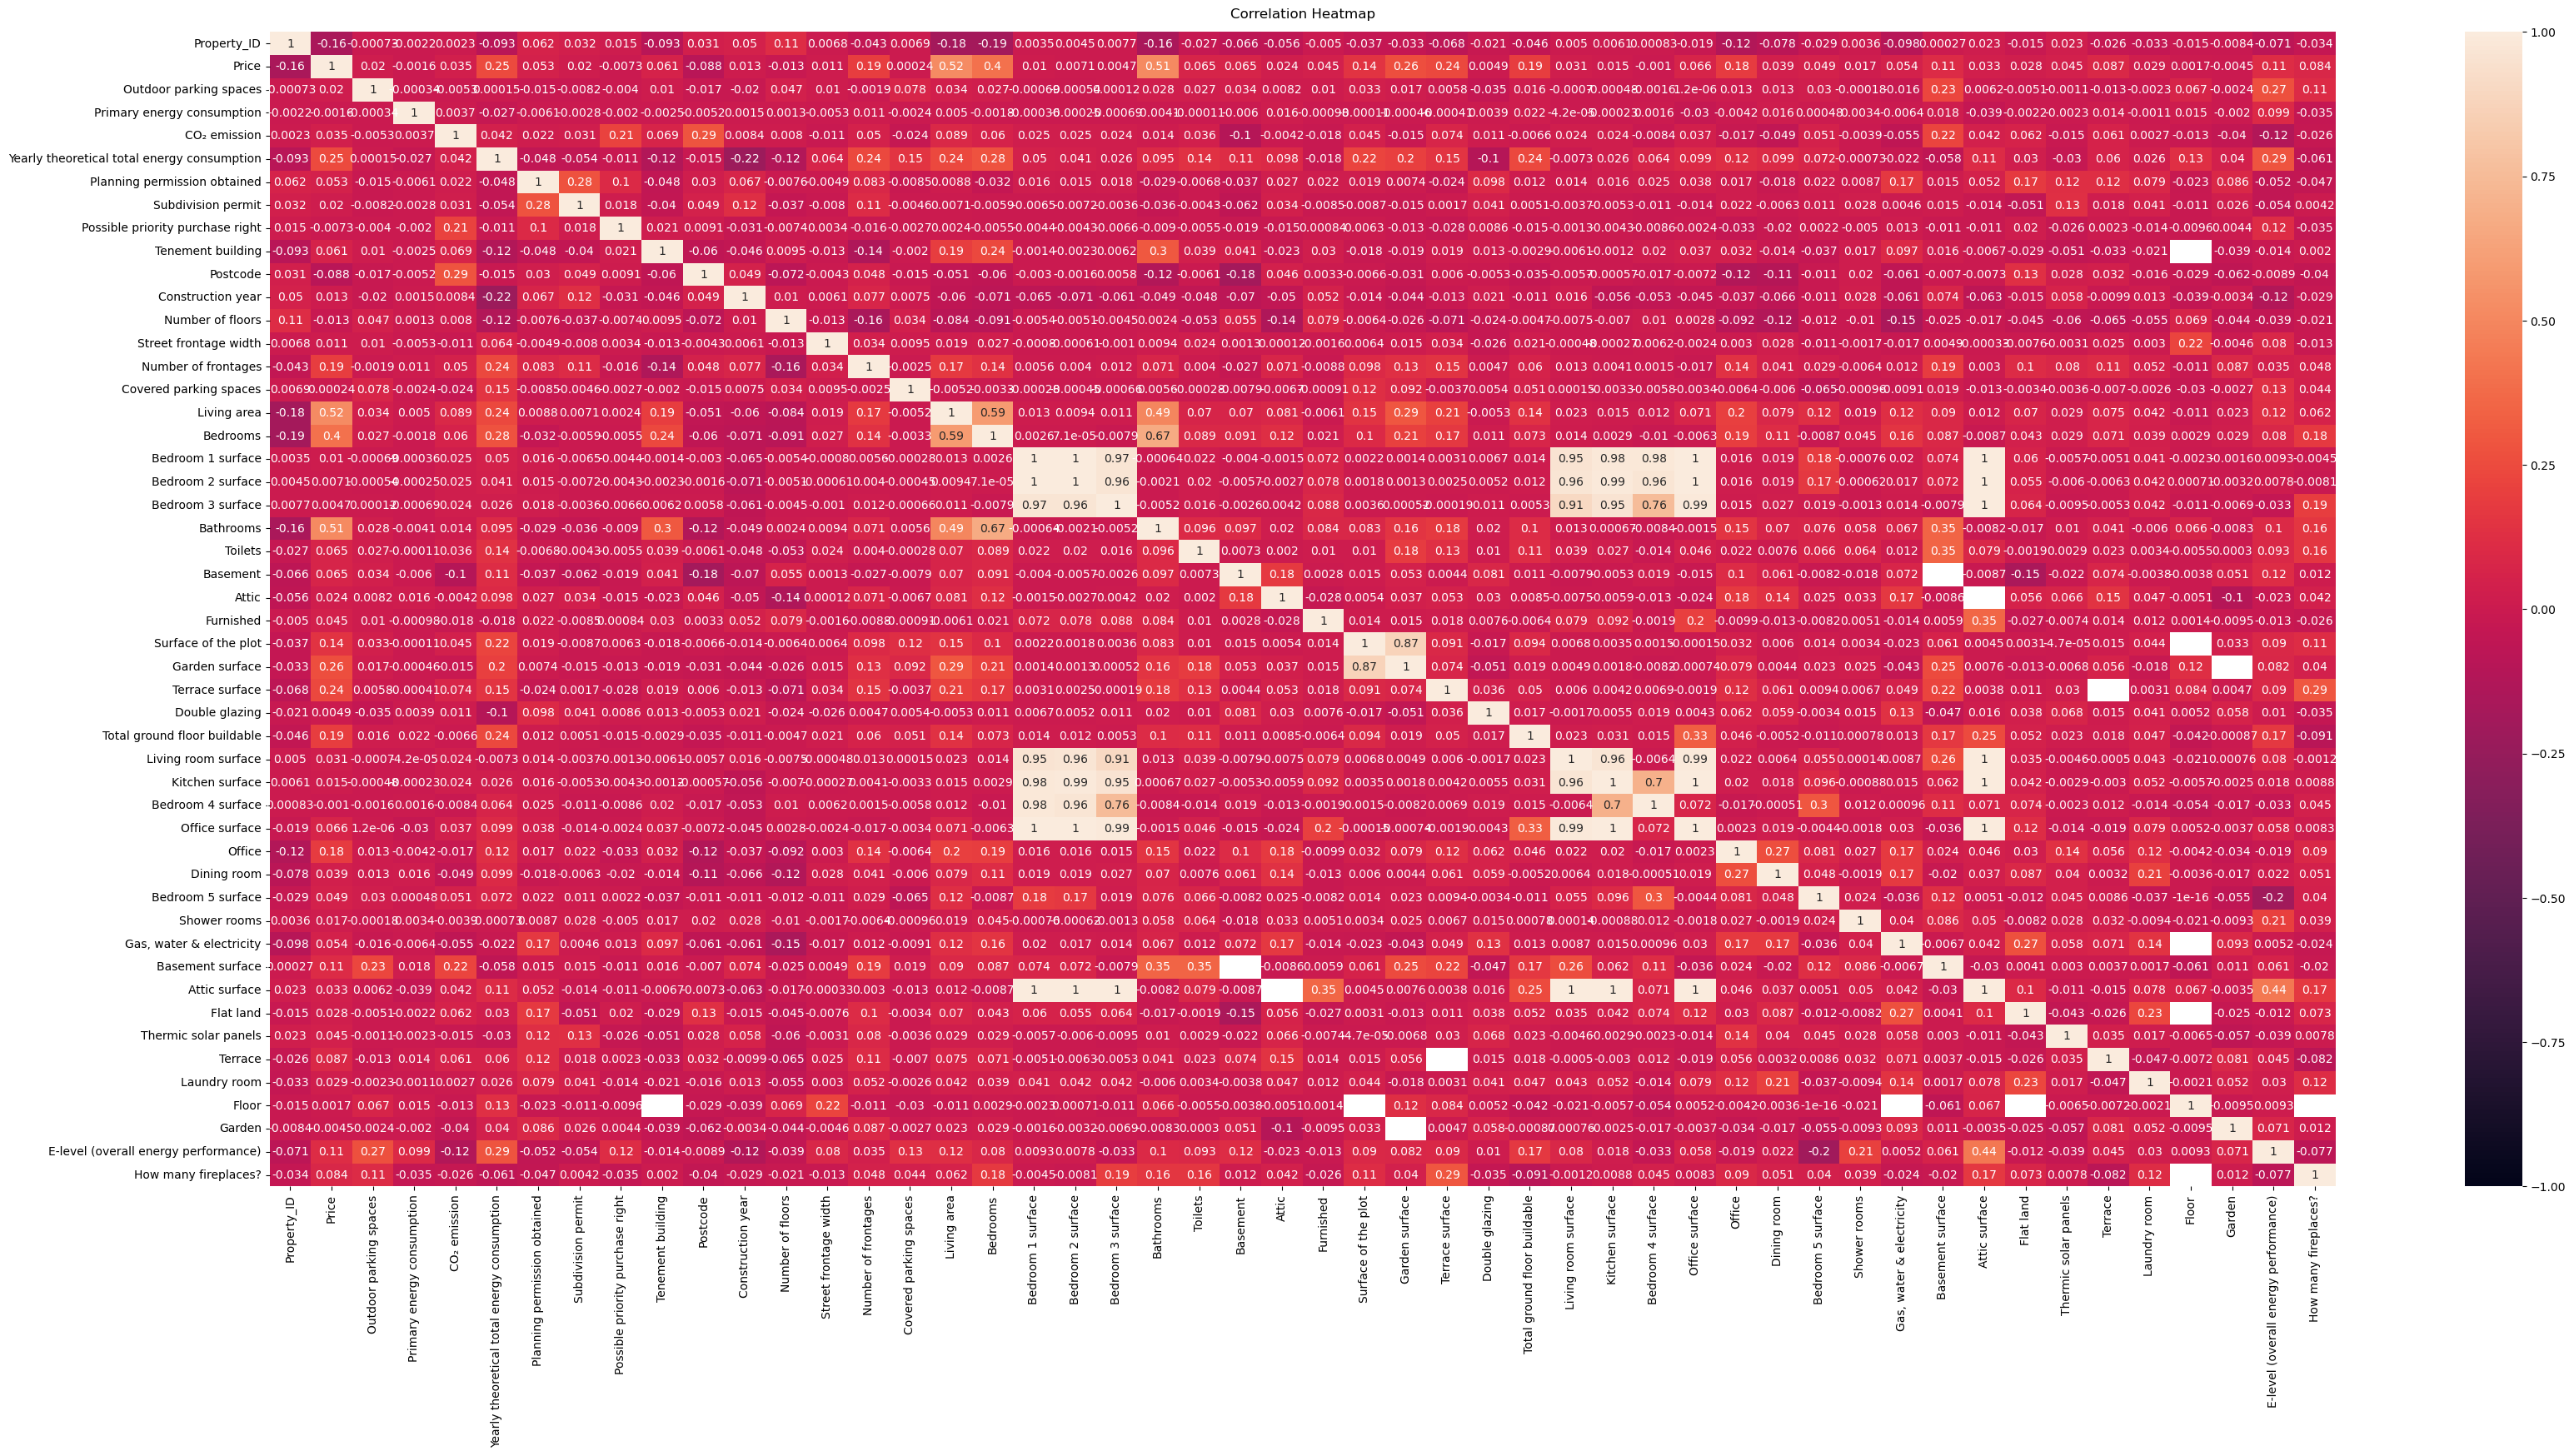

In [31]:
plt.figure(figsize=(40, 18))

# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.

heatmap = sns.heatmap(immo.corr(numeric_only=True), vmin=-1, vmax=1, annot=True)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.

heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

26 
 ['Type_of_property', 'Planning permission obtained', 'Subdivision permit', 'Possible priority purchase right', 'Proceedings for breach of planning regulations', 'Tenement building', 'Basement', 'Attic', 'Furnished', 'As built plan', 'Double glazing', 'Office', 'Connection to sewer network', 'Dining room', 'Armored door', 'Gas, water & electricity', 'Dressing room', 'Professional space', 'Flat land', 'Heat pump', 'Photovoltaic solar panels', 'Thermic solar panels', 'Common water heater', 'Terrace', 'Laundry room', 'Garden']


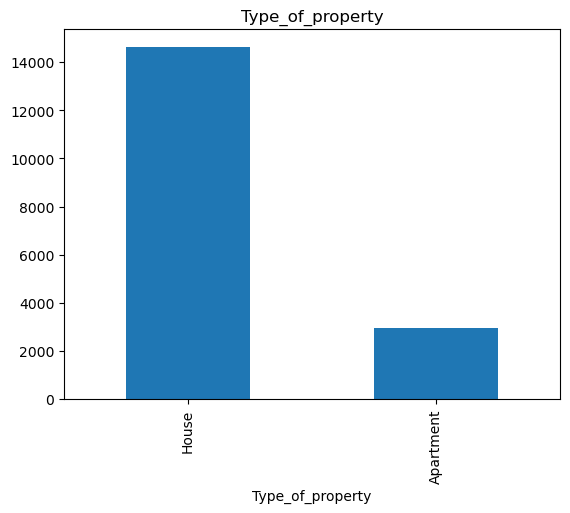

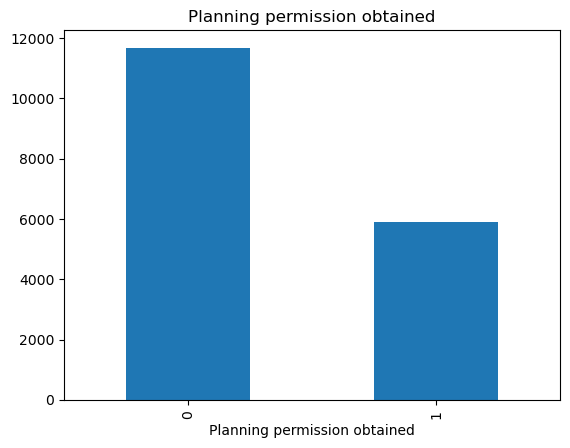

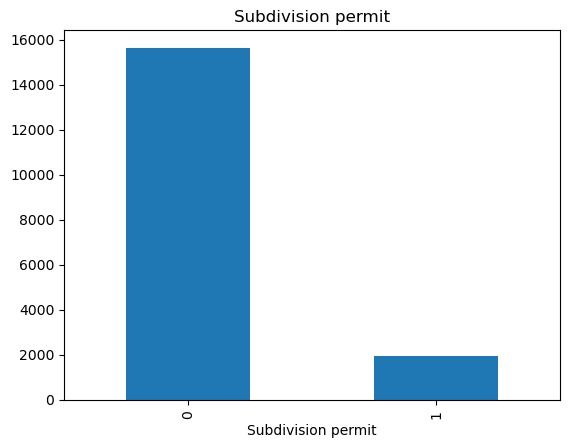

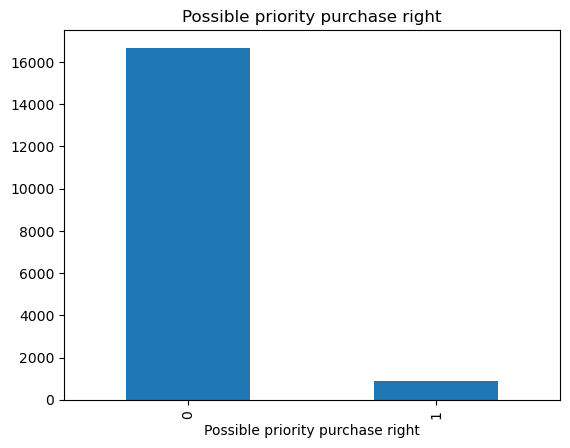

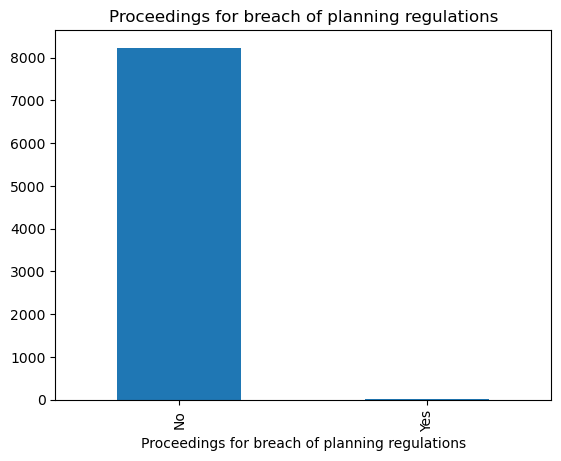

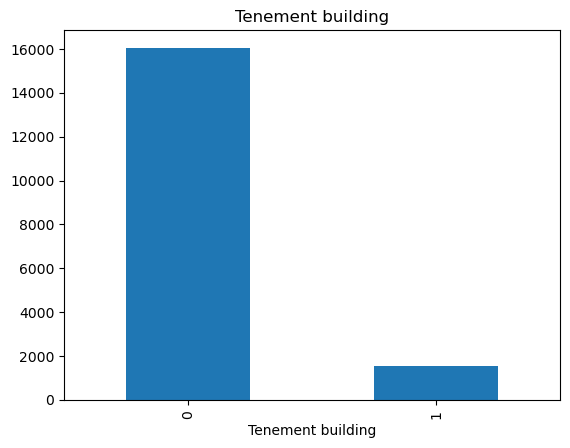

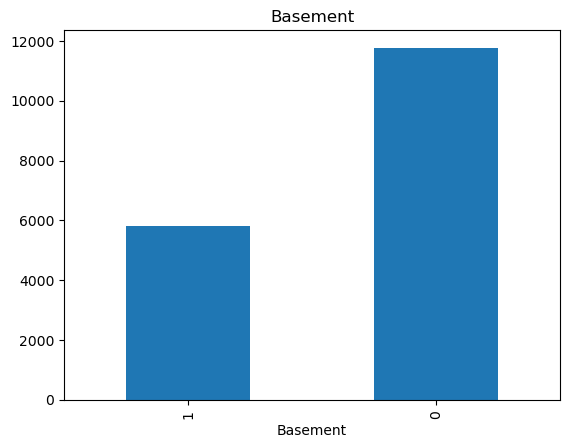

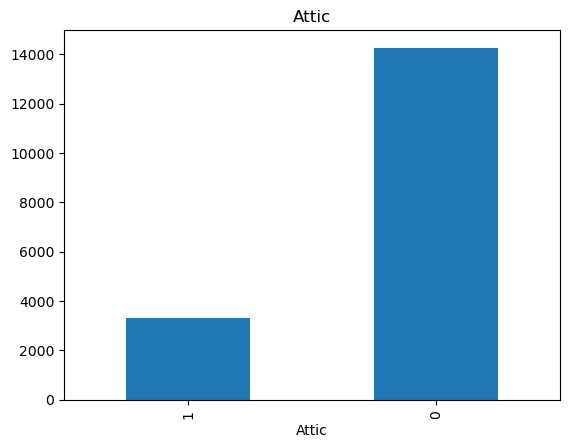

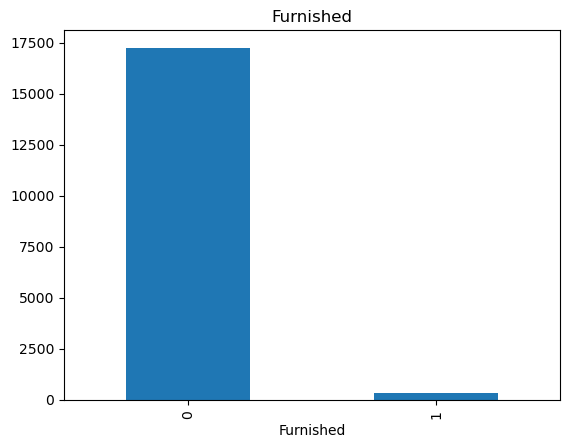

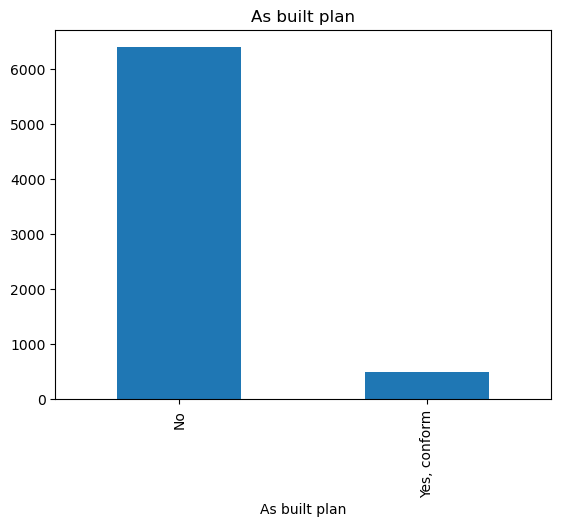

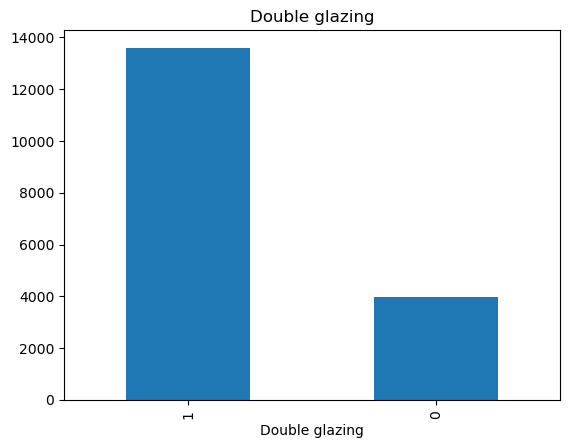

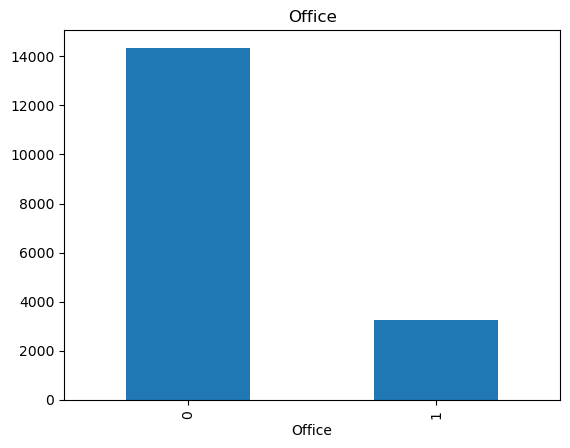

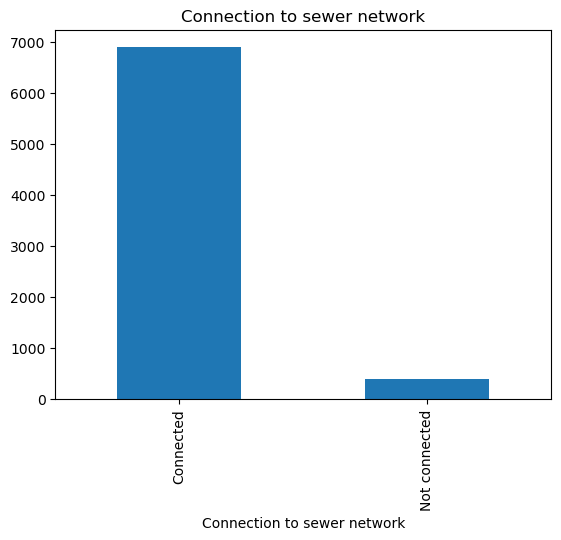

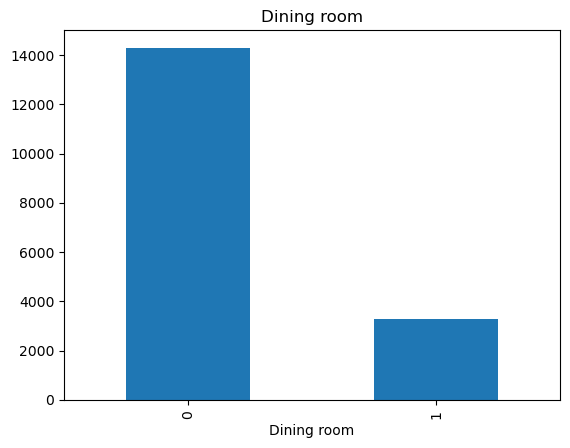

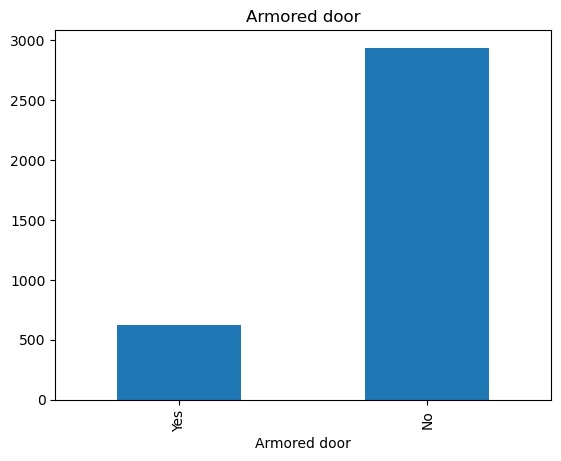

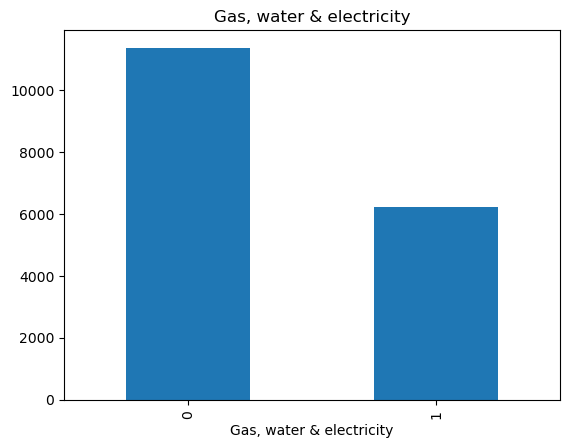

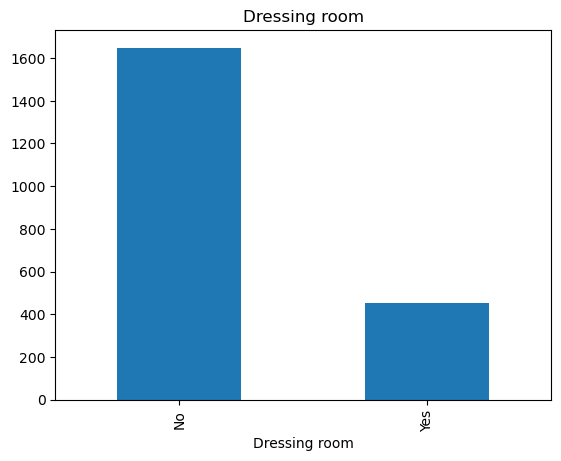

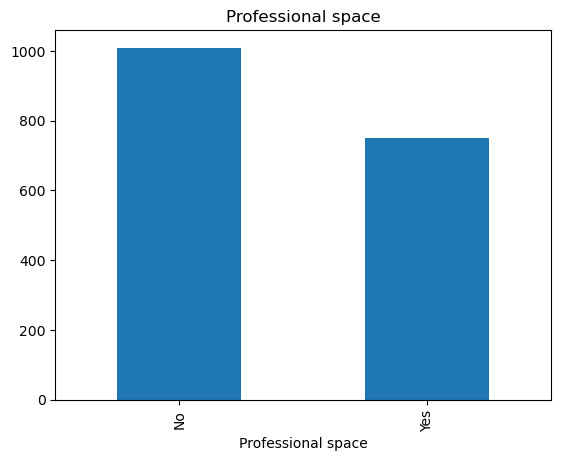

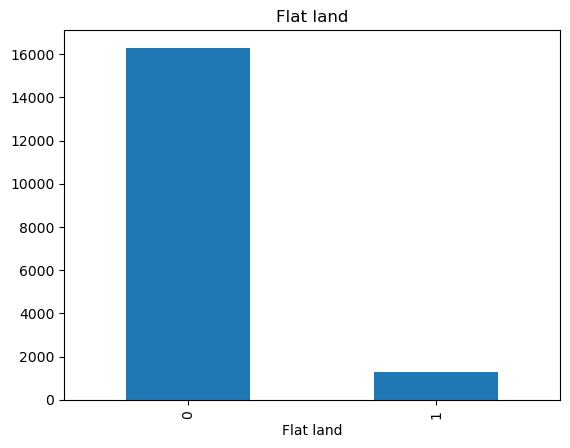

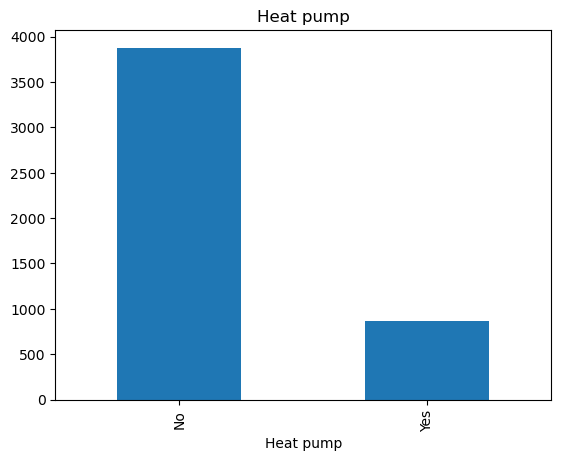

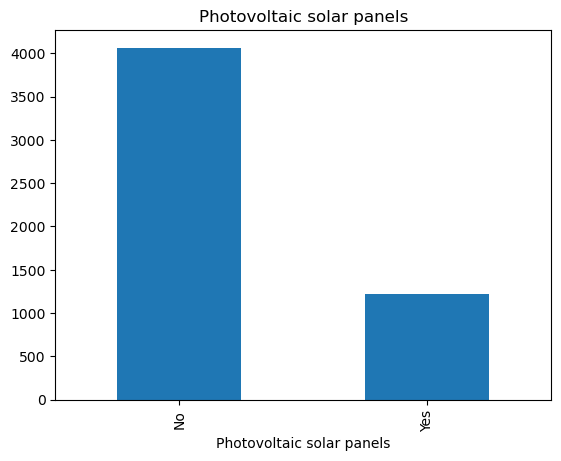

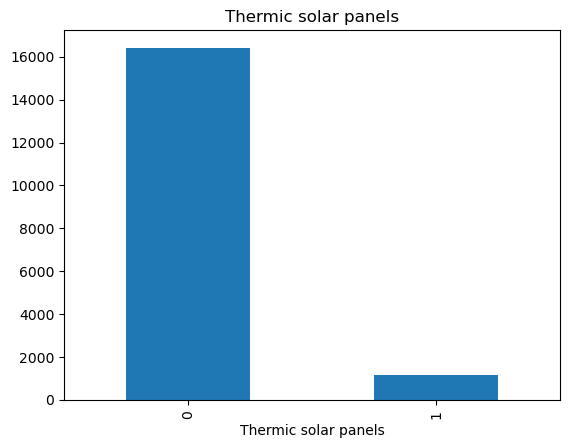

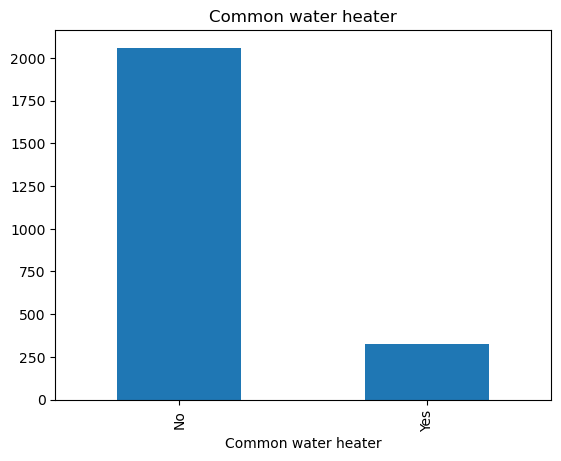

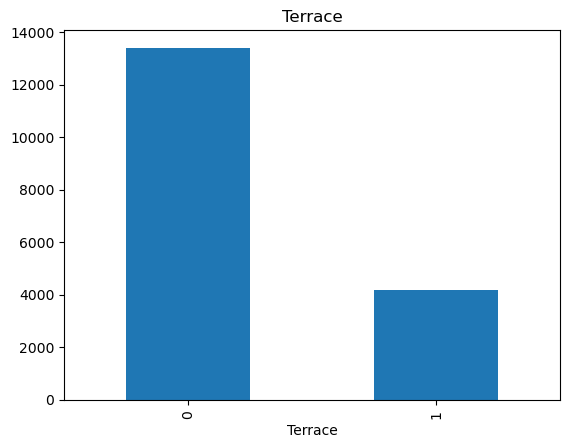

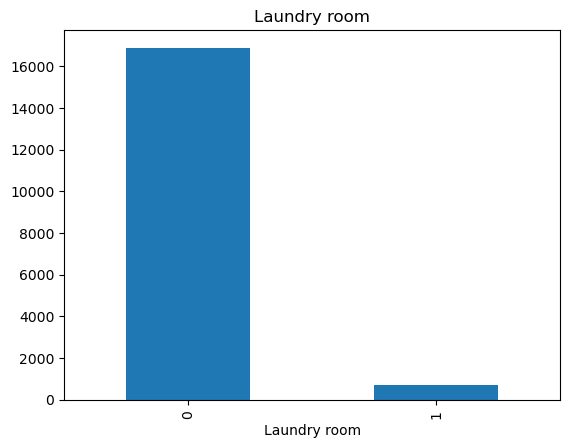

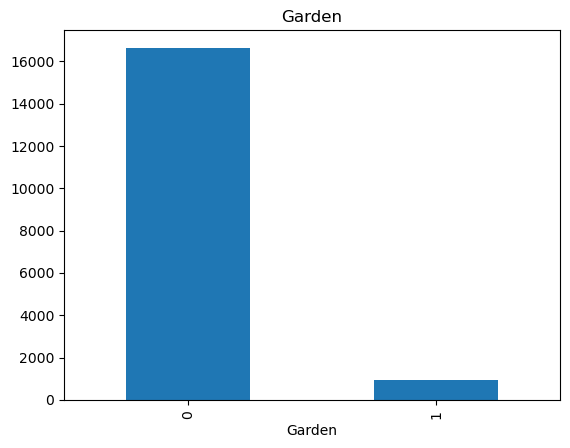

In [32]:
binary_list = []
for column in immo.columns:
    if len(immo[column].value_counts()) == 2:
        binary_list.append(column)
print(len(binary_list), '\n',binary_list)


for i in range(len(binary_list)):
    immo[binary_list[i]].value_counts(sort=False).plot.bar().set_title(f'{binary_list[i]}')

    plt.show()



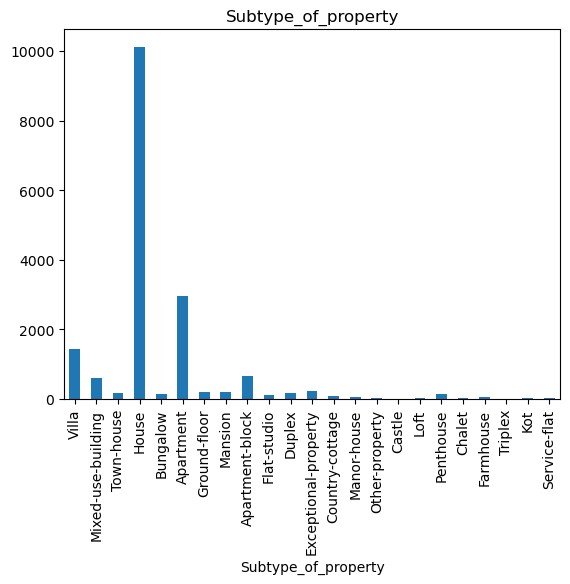

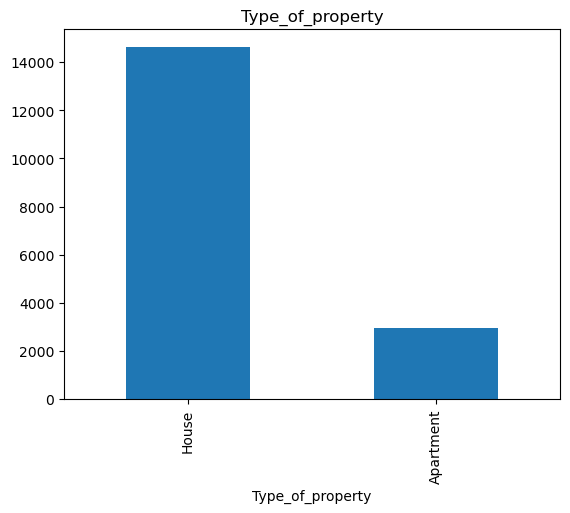

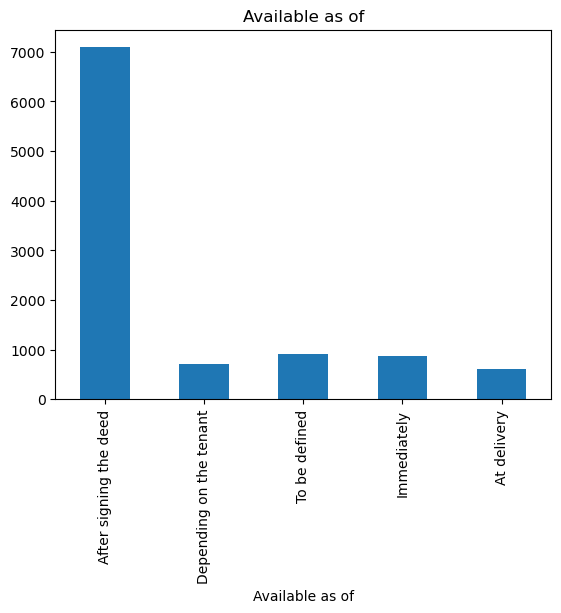

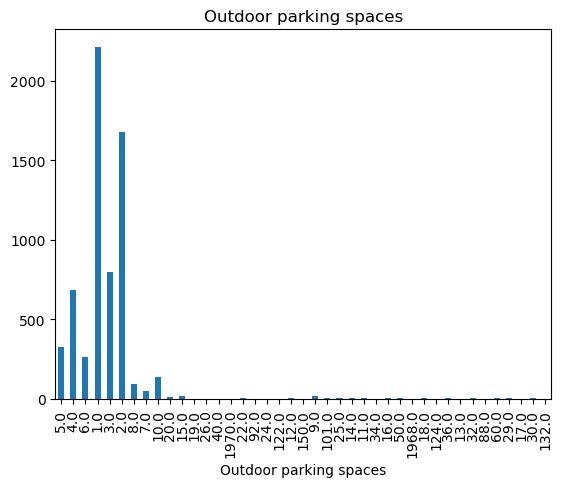

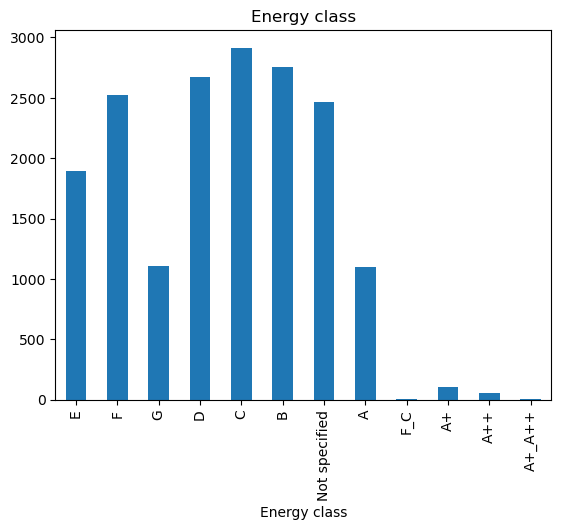

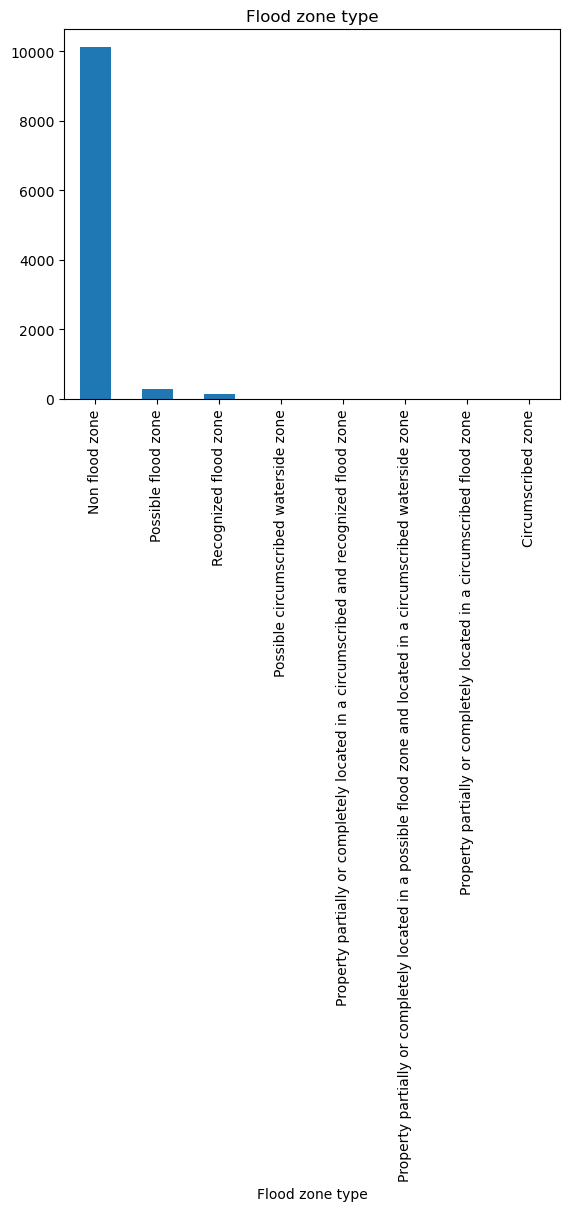

In [33]:
# Useful columns
values_list = ['Subtype_of_property', 'Type_of_property', 'Available as of', 'Outdoor parking spaces',
               'Energy class', 'Flood zone type']
for column in immo[values_list]:
    immo[column].value_counts(sort=False).plot.bar().set_title(f'{column}')
    plt.show()

# Preprocessing

Here we perform the type casting